In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

%run utility_functions.py # functions reused throughout

0    16258
1     1639
Name: 0, dtype: int64

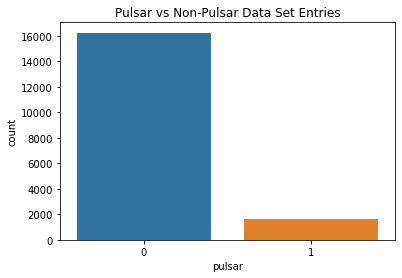

In [2]:
# Dataset source:
# http://archive.ics.uci.edu/ml/datasets/HTRU2#

# Read in data
data = pd.read_csv('../data/HTRU2/HTRU_2.csv', sep=',')

sns_plot = sns.countplot(data.iloc[:,-1]) # plot number of things with each value
sns_plot.set(xlabel='pulsar', title='Pulsar vs Non-Pulsar Data Set Entries')
fig = sns_plot.get_figure()
fig.savefig('../images/data_imbalance_pulsar.png')

data.iloc[:,-1].value_counts(sort=True)
# skewed toward predicting negative

In [3]:
# Create training, testing, and validation sets

X = data.drop(data.columns[-1], axis=1) # last value is the pulsar indicator

y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

In [4]:

clf = DecisionTreeClassifier()

parameters = {'random_state': [0],
              'criterion': ['entropy', 'gini'],
              'splitter': ['best', 'random'],
              'max_depth': [1, 4, 6, 8, 10], 
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 20],
              'ccp_alpha': [0.0, .001, .002, .003, .004, .005],
              'max_features': ['log2', 'sqrt','auto'],
             }

# scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=10, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_

# Fit to the data. 
clf.fit(x_train, y_train)

clf.get_params()


{'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

No Skill: ROC AUC=0.500
Model: ROC AUC=0.971


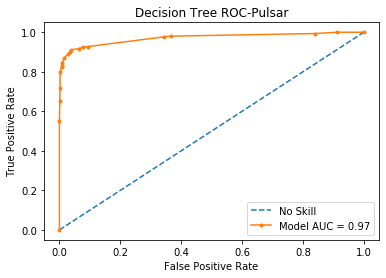

Model: f1=0.864 auc=0.918


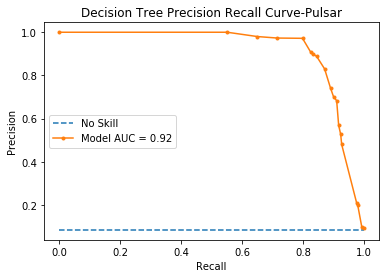

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3277
           1       0.90      0.83      0.86       303

    accuracy                           0.98      3580
   macro avg       0.94      0.91      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix
[[3249   28]
 [  51  252]]


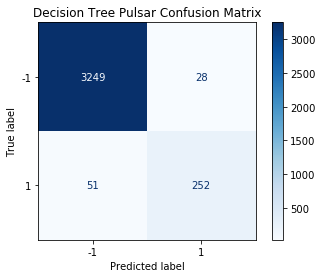

<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

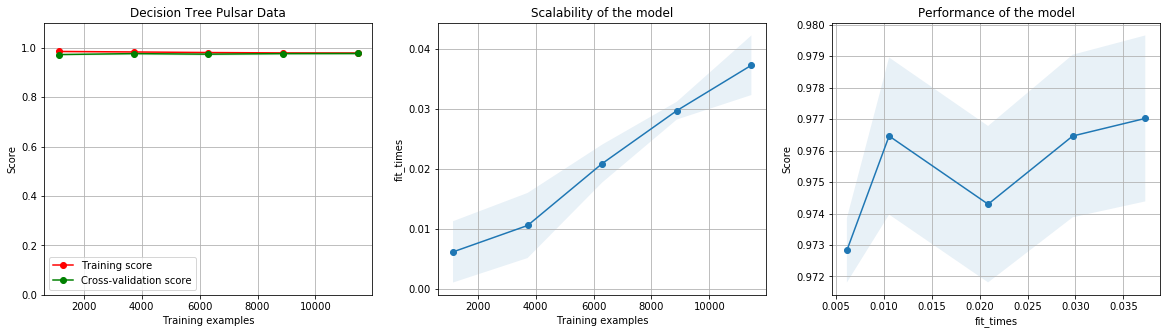

In [5]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'Decision Tree ROC-Pulsar')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'Decision Tree Precision Recall Curve-Pulsar')

# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels=['-1', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
cm.ax_.set_title('Decision Tree Pulsar Confusion Matrix')
plt.savefig('../images/cm_DT_Pulsar.png')
plt.show()

#print('Accuracy')
#print(accuracy_score(y_test, y_predict))

# for unbalanced data
#print('Balanced Accuracy')
#print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Decision Tree Pulsar Data", x_train, y_train, ylim=[0,1.1])

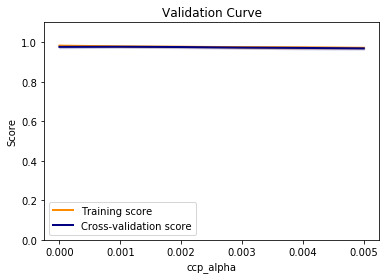

In [6]:
plot_model_complexity_analysis(clf, 'ccp_alpha', [0.0, .001, .002, .003, .004, .005], 'DT_pulsar', x_train, y_train)

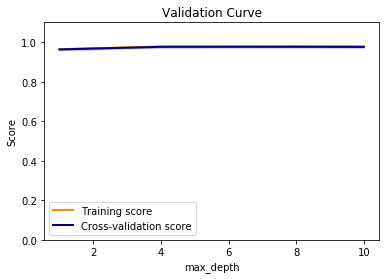

In [7]:
plot_model_complexity_analysis(clf, 'max_depth', [1, 4, 6, 8, 10], 'DT_pulsar', x_train, y_train)

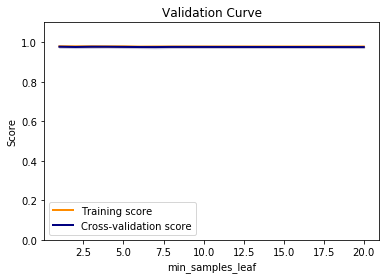

In [8]:
plot_model_complexity_analysis(clf, 'min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 20], 'DT_pulsar', x_train, y_train)

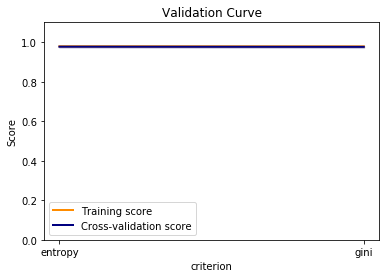

In [9]:
plot_model_complexity_analysis(clf, 'criterion', ['entropy', 'gini'], 'DT_pulsar', x_train, y_train)

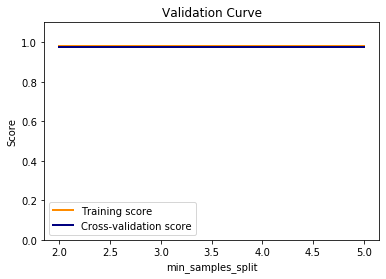

In [10]:
plot_model_complexity_analysis(clf, 'min_samples_split', [2, 3, 4, 5], 'DT_pulsar', x_train, y_train)

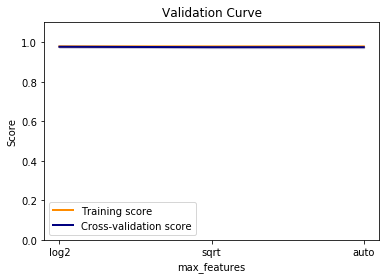

In [11]:
plot_model_complexity_analysis(clf, 'max_features', ['log2', 'sqrt','auto'], 'DT_pulsar', x_train, y_train)